# Жаров Всеволод, Младший исследователь данных (DS NLP)

Описание задачи:

Одним из приоритетов нашего бизнеса является создание лучшего клиентского опыта, поэтому для компании важно понимать текущий уровень CSI (customer satisfaction index) и его динамику (для оценки эффекта изменений в бизнес-процессах).  
С этой целью, разработан автоматический механизм сбора обратной связи по заказам. Кроме общей оценки удовлетворённости, клиенты оставляют обратную связь в виде текстового комментария/отзыва в свободной форме.  
Вам необходимо обучить модель классификации негативных отзывов, которая позволит получать детальную аналитику по проблемам клиентов в автоматическом режиме.

Краткое описание способа решения задачи:

Предобработка текста осуществлялась с помощью `лемматизации` и `очистки` от ненужных слов и символов (стоп-слова, пунктуация, смайлики и тд)  
Токенизация с помощью библиотеки `youtokentome` по методу `Byte Pair Encoding`, мешка n-грамм. Библиотека написана на С++, поэтому для её работы нужно обязательно Miscrosoft Visual Studio Build Tools для Windows или gcc++ для Linux. Без этих инструментов библиотека работать `не будет` (пример установки на linux с requirements.txt приведён в `Dockerfile`).  
Модель `BERT`-архитектуры, написанная с помощью собственных блоков. Для обучения используется `lightning` и `hydra` для менеджмента конфигов.  
Итоговая модель выгружена в формат `onnx`.  

Также, согласно ТЗ, в файле `model.py` в папке пакета `negative_classification` есть необходимая функция `get_result`.

## Импорты библиотек

In [1]:
import pandas as pd
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import numpy as np
import matplotlib.pyplot as plt
import re
import youtokentome as yttm
from sklearn.model_selection import train_test_split
import lightning as L

L.seed_everything(1702)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alagril/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Seed set to 1702


1702

## Загрузка данных и их анализ

Для начала необходимо посмотреть, как выглядят данные, что они из себя представляют

In [6]:
# Относительный путь к данным для обработки в формате *.xlsx
filepath = "negative_classification/dataset/ds_nlp.xlsx"

In [7]:
def load_dataset(filename: str) -> (np.array, np.array):
    """Фунция для загрузки файла в формате *.xlsx и с колонками text и class"""
    df = pd.read_excel(
        io=filename,
        header=[0],
        index_col=0
    )
    x, y = df["text"].to_numpy(dtype=str), df["class"].to_numpy(dtype=str)
    return x, y

In [8]:
text, labels = load_dataset(filepath)

In [22]:
print(labels[:10])
print()
print(text[:10])

['Консультация КЦ' 'Компетентность продавцов/ консультантов'
 'Компетентность продавцов/ консультантов'
 'Компетентность продавцов/ консультантов'
 'Компетентность продавцов/ консультантов' 'Консультация КЦ'
 'Компетентность продавцов/ консультантов' 'Электронная очередь'
 'Электронная очередь' 'Компетентность продавцов/ консультантов']

[' негатив к вам и горячей линии которые нафиг не нужны!!! вообще ничего не решают!!!'
 'перестаньте впаривать клиентам дополнительные товары и услуги, надоело стараться любезно от этих приставаний отбиваться. '
 ' продавец предложил наклеить защитную плёнку за 1300 рублей (с учётом скидки). что сложного сказать покупателю сразу честную цену за товар (услугу)? это конечно не много, но очень не приятно!'
 'продавец режил продать нам товар почему то по завышенной цене. '
 'навязанные услуги ( без моего согласия) на сумму 1949 рубле'
 'оператор проигнорировала информацию об ошибке приложения, не исправила контактную информацию в заказе.'
 'сотрудник мало 

Итак, что мы можем видеть. 
- Тексты отзывов очень сильно отличаются по размеру. В выборке можно найти как отзыв, состоящий всего из одного слова "отзыв", так и целые абзацы, где недовольный покупатель подробно расписывает, что и в каком порядке с ним произошло.
- В отзывах могут присутствовать сокращения, опечатки, обилие пунктуационных знаков (вроде "!!!"), иногда даже попадаются смайлики (пример будет приведён ниже, в разделе `очистки данных`)

Посмотрим на классы отзывов, на которые мы должны разделить выборку, и сразу составим словарик перевода этих классов в числовой вариант

In [9]:
unique_labels, count_unique_labels = np.unique(labels, return_counts=True)
print(unique_labels)

print()

label_to_num = dict()
for idx in range(len(unique_labels)):
    label_to_num[unique_labels[idx]] = idx

print(label_to_num)

['Вежливость сотрудников магазина' 'Время ожидания у кассы'
 'Доступность персонала в магазине'
 'Компетентность продавцов/ консультантов' 'Консультация КЦ'
 'Обслуживание на кассе' 'Обслуживание продавцами/ консультантами'
 'Электронная очередь']

{'Вежливость сотрудников магазина': 0, 'Время ожидания у кассы': 1, 'Доступность персонала в магазине': 2, 'Компетентность продавцов/ консультантов': 3, 'Консультация КЦ': 4, 'Обслуживание на кассе': 5, 'Обслуживание продавцами/ консультантами': 6, 'Электронная очередь': 7}


Всего у нас 8 классов. Можно сразу отметить, что некоторые классы могут между собой перекликаться (вроде "Компетентность продавцов/ консультантов" и "Обслуживание продавцами/ консультантами", у которых могут быть плюс-минус схожие ключевые слова)

In [16]:
def plot_unique_labels(labels, plot_name = "Распределение уникальных значений"):
    """Функция для построение графика распределения классов в выборке"""
    unique_labels, count_unique_labels = np.unique(labels, return_counts=True)
    plt.barh(width = count_unique_labels, y=list(unique_labels))
    plt.title(plot_name)
    plt.show()

In [28]:
count_unique_labels

array([500, 306, 293, 825, 170, 212, 267, 264])

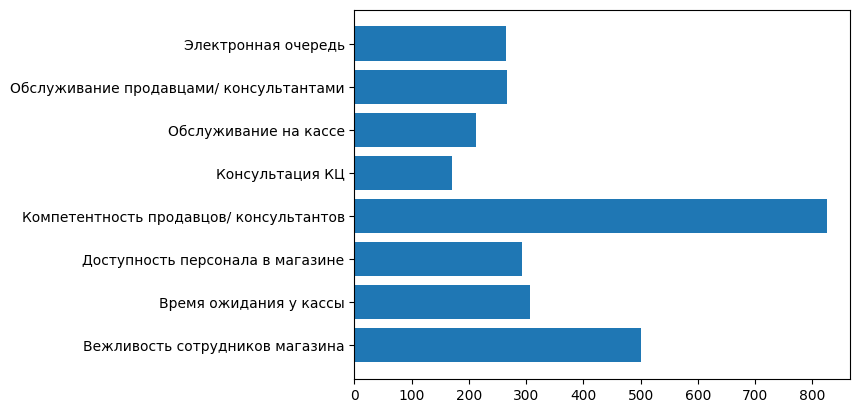

In [35]:
plt.barh(width = count_unique_labels, y=list(unique_labels))
plt.show()

По графику видно, что количество примеров для каждого класса в нашей выборке у нас очень сильно отличается (От меньше 200 по нижней границе у класса "Консультация КЦ" до более 800 примеров верхней границы "Компетентность продавцов/ консультантов").  
При этом самих данных не очень много (всего 2800+ примеров для тренировочной и тестовой выборки), из-за чего сравнять классы просто доведением до средней границы смотрится не самой хорошей идеей.

## Предобработка данных

Поскольку у нас задача классификации текстов, задача сохранить для анализа исходный вариант отзыва у нас не стоит, нам важно передать только суть. Поэтому для сокращения словаря мы используем `лемматизацию` - приведение исходного слова в его начальную форму.

Также необходимо убрать "стоп-слова" - слова, которые часто встречаются в речи, но при этом несут очень мало смысловой нагрузки - и знаки пунктуации, которые в нашей задаче практически не несут смысла, при этом сокращая словарь

### Лемматизация и очистка данных

Лемматизацию проводим с помощью библиотеки `pymystem3`

In [4]:
mystem = Mystem()

Также из библиотеки `nltk` возьмём список стоп-слов

In [5]:
russian_stopswords = stopwords.words("russian")
np.array(russian_stopswords)

array(['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как',
       'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у',
       'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот',
       'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда',
       'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть',
       'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь',
       'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут',
       'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем',
       'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже',
       'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того',
       'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом',
       'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были',
       'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец',
       'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот',
 

И знаки пунктуации из встроенного модуля `string`

In [6]:
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [47]:
def text_lemmatize(text):
    """Функция для лемматизации текста с помощью библиотеки pymystem3"""
    lemma_texts = [mystem.lemmatize(phrase) for phrase in text]
    answer = []
    for phrase in lemma_texts:
        temp_phrase = [token for token in phrase if token not in russian_stopswords and token != " " and token.strip() not in punctuation]
        answer.append(temp_phrase)
    return answer

In [50]:
# Лемматизация текста
lemma_texts = text_lemmatize(text)

In [10]:
# Перевод классовых меток из текста в числа
num_labels = [label_to_num[label] for label in labels]

Посмотрим на то, как выглядит текст отзыва после лемматизации и удалении стоп-слов и знаков пунктуации

In [60]:
for i in range(5):
    print(text[i], " -- ", labels[i])
print("-----")
for i in range(5):
    print(lemma_texts[i], " -- ", num_labels[i])

 негатив к вам и горячей линии которые нафиг не нужны!!! вообще ничего не решают!!!  --  Консультация КЦ
перестаньте впаривать клиентам дополнительные товары и услуги, надоело стараться любезно от этих приставаний отбиваться.   --  Компетентность продавцов/ консультантов
 продавец предложил наклеить защитную плёнку за 1300 рублей (с учётом скидки). что сложного сказать покупателю сразу честную цену за товар (услугу)? это конечно не много, но очень не приятно!  --  Компетентность продавцов/ консультантов
продавец режил продать нам товар почему то по завышенной цене.   --  Компетентность продавцов/ консультантов
навязанные услуги ( без моего согласия) на сумму 1949 рубле  --  Компетентность продавцов/ консультантов
-----
['негатив', 'горячий', 'линия', 'который', 'нафиг', 'нужный', '!!!', 'вообще', 'ничто', 'решать', '!!!']  --  4
['переставать', 'впаривать', 'клиент', 'дополнительный', 'товар', 'услуга', 'надоедать', 'стараться', 'любезно', 'приставание', 'отбиваться']  --  3
['продавец

In [93]:
# Пример текста со смайликом
print(lemma_texts[88])

['продавец', 'подходить', 'избегать', 'уметь', 'здороваться', 'красиво', 'стоять', 'кучка', 'приходиться', 'ловить', 'продавец', 'который', 'идти', 'пара', 'ключ', 'машина', 'рука', 'который', 'купить', '😃', 'отличие']


Во-первых, видно, что удаление знаков пунктуации не везде помогло - всё ещё остались случаи, когда несколько знаков пунктуации идут подряд (например, "!!!"). Также метод не убирает цифры, которые для определения класса отзыва вообще не играют никакую роль. Плюс к тому, ещё существуют смайлики в отзывах, которые сложно обрабатываются

Для очистки отзывов от смайликов и иных мелочей, которые лучше не обрабатывать перед построением словаря, можно воспользоваться регулярным выражением `[а-яА-Я ]+`. В этом случае в тексте отзывов останутся только буквы и пробелы

In [91]:
def for_txt_file(texts, filename):
    """Фунция оставляет в тексте только символы букв и пробелы с помощью регулярного выражения, 
    а также записыват текст в файл .txt формата для дальнейшей обработки токенизатором"""
    file = open(filename, "w")
    for phrase in texts:
        phr = " ".join(phrase)
        phr = re.findall("[а-яА-Я ]+", phr)
        phr = " ".join(phr) + "\n"
        file.write(phr)
    file.close()

In [7]:
# Путь до нового файла в формате .txt для записи предобработанного текста
filename_lemma = "negative_classification/dataset/neg_text.txt"

In [92]:
for_txt_file(lemma_texts, filename_lemma)

Посмотрим, все ли тексты перекодировались правильны и не исчезли ли какие-то отзывы. В файле их 2837

In [95]:
len(lemma_texts)

2837

Что после лемматизации, что после очистки регулярными выражениями количество отзывов осталось равным 2837. Значит, ничего из них не потерялось, и мы можем в дальнейшем подгружать отзывы из уже предобработанного txt-файла

### Построение словаря с помощью Byte-Pair Encoding

Поскольку у нас задача на специфичную область, словарь токенов нам нужен специфичный и отражающий нашу область и проблематику. Поэтому словарь будем строить с помощью мешка n-грамм, реализованного через BPE библиотеки youtokentome. Таким образом для наших конкретных текстов построиться словарь, который будет отражать конкретную специфичную выборку.  
Однако надо подобрать размер словаря, который будет лучше всего аппроксимировать самые частые n-граммы

In [2]:
filename_lemma = "negative_classification/dataset/neg_text.txt"
VOCAB_SIZE = 300
BPE_MODEL_FILENAME = f"negative_classification/models/bpe_{VOCAB_SIZE}.yttm"
#-----
# yttm.BPE.train(data=filename_lemma, vocab_size=VOCAB_SIZE, model=BPE_MODEL_FILENAME)
#-----
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)
print(" ".join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ а о т н е и р ь с в к д п л з у м ы й я ч б г ж х ц ш щ э ф ю ъ ть ать ▁п ▁с ▁о ка ни то ▁в ▁по ый ро вать ра ▁з ▁м да ер ▁за ин ить та ный ▁н от каз ен ▁к ел но ся ▁про ние од ▁д ва ру ник он ▁вы ри ять ве ▁заказ ▁от во га одить ед ходить ▁ма ▁то руд ча ▁сот ▁сотруд ▁у ▁ра ение ▁сотрудник ол ли ▁выда ▁на ст лу зин ▁мага ▁магазин ывать ▁при ре ▁оч ▁ка тел вар ▁об ла ▁товар ль сс ▁х ▁выдача уп го тель ивать ти ▁прода ▁б ▁и ▁касс ▁э ▁ко ес жд ий чать ко вец ▁продавец ло куп еред ид ▁покуп ма ▁раб тор ир ждать ▁очеред ень ▁очередь ▁ч мо ▁не еть об ле ▁та лять ▁т ▁под ▁полу аться су ▁сто ▁касса ор ент ис ▁во ▁оп ▁пер ▁это ста слу жи ▁приходить ▁ждать ск ет ▁мин ело ▁кон ▁дол ци вый ам сто ▁до казывать она лон ▁мину ▁работ ▁г ▁минута ▁талон атель нный жа ▁очень торый тер влять сть суль ▁который вой ▁консуль про ▁хот ▁сп ▁кли ство ▁консульта ▁ин ▁а ▁покупатель кт казать ▁сказать нт ▁чело ▁со ▁челове ▁получать ▁человек на прос ▁вид ит ина гать ▁работать ▁хам ▁консуль

В словаре, помимо токенов, встречающихся в текста, существуют ещё 4 служебных токена:
- `<PAD>` токен паддинга, нулевой токен. Необходим для паддинга, чтобы модель понимала, что этот токен ничего не значит
- `<UNK>` токен для неизвестного словарю символа, если вдруг такой в тексте попадётся
- `<BOS>` токен начала строки (отзыва)
- `<EOS>` токен конца строки (отзыва)

Были рассмотрены словари разных размеров (200, 300, 400, 500, 800 слов). При рассмотрении (и обучении различных моделей) оптимальным смотрится словарь из 300 символов (так как при расширении какого-то заметного прироста это не даёт, а при уменьшении качество модели уже падает)

In [3]:
def load_text_from_file(filename):
    """Функция для загрузки из txt-файла текста"""
    with open(filename) as f:
        lines = [line[:-1] for line in f.readlines()]
    return lines

In [4]:
lemma_text = load_text_from_file(filename_lemma)

Посмотрим, что все тексты на месте, их количество - 2837 - не изменилось, и тексты соответсвуют классовым токенам

In [11]:
print(len(lemma_text))
print(lemma_text[:5])
print(len(num_labels))
print(num_labels[:5])


2837
['негатив горячий линия который нафиг нужный   вообще ничто решать ', 'переставать впаривать клиент дополнительный товар услуга надоедать стараться любезно приставание отбиваться', 'продавец предлагать наклеивать защитный пленка   рубль учет скидка сложный сказать покупатель сразу честный цена товар услуга это очень приятный', 'продавец реживать продавать товар почему завышать цена', 'навязывать услуга согласие сумма   рубль']
2837
[4, 3, 3, 3, 3]


Поделим выборку на тренировочную и тестовую (валидационную, потому что по ней мы подбираем гиперпараметры). Возьмём 10% для валидационной части с помощью функции train_test_split из библиотеки scikit-learn

In [14]:
train_text, val_text, train_labels, val_labels = train_test_split(lemma_text, num_labels, test_size=0.1)

print(len(train_text))
print(len(val_text))

2553
284


Поскольку выборка в тренировочную и тестовую часть происходит случайно, посмотрим, не изменилось ли у нас распределение (какой-то класс, например, практически вообще не попал в какую-то из выборок)

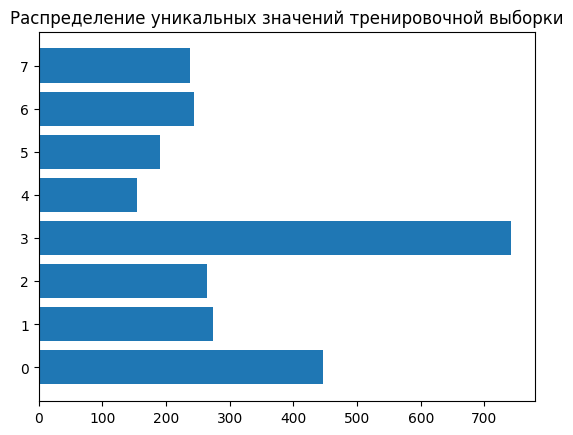

In [17]:
plot_unique_labels(train_labels, plot_name="Распределение уникальных значений тренировочной выборки")

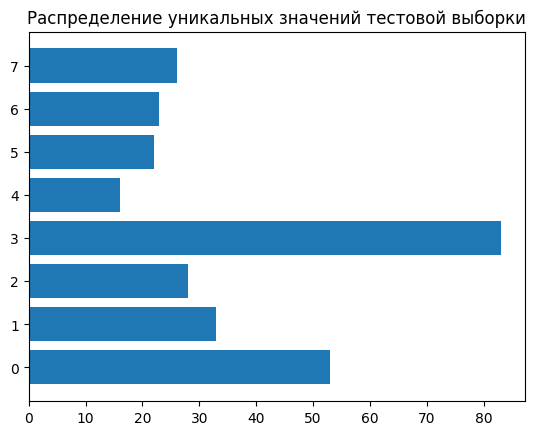

In [18]:
plot_unique_labels(val_labels, plot_name="Распределение уникальных значений тестовой выборки")

Как видно из графиков, распределение осталось такое же у всех

Теперь совершим токенизацию текста!

In [19]:
train_tokens = tokenizer.encode(train_text, bos=True, eos=True)
val_tokens = tokenizer.encode(val_text, bos=True, eos=True)

Осталось определить ещё одну вещь - длину отзыва, которую будет обрабатывать модель, которая у всех должна быть одинаковой. Тексты отзывов и до этого были распределены в достаточно большом диапазоне возможных длин, а после токенизации, когда замена буквенных символов в токены не одинакова по размеру, амплитуда длин может быть ещё больше

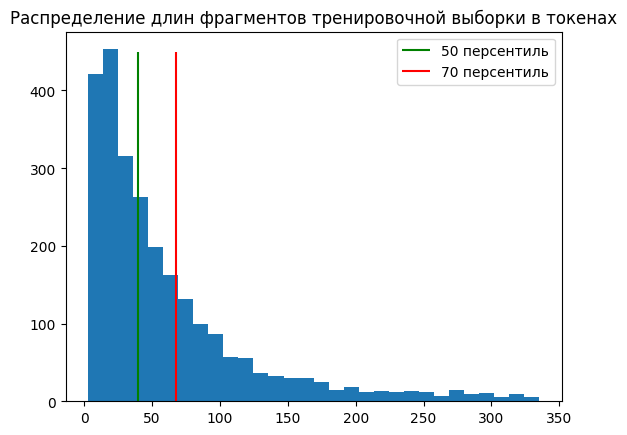

In [36]:
plt.hist([len(sentence) for sentence in train_tokens], bins=30)
plt.vlines([np.percentile([len(sentence) for sentence in train_tokens], 50)], [0], [450], label="50 персентиль", color="green")
plt.vlines([np.percentile([len(sentence) for sentence in train_tokens], 70)], [0], [450], label="70 персентиль", color="red")
plt.title('Распределение длин фрагментов тренировочной выборки в токенах')
plt.legend()
plt.show()

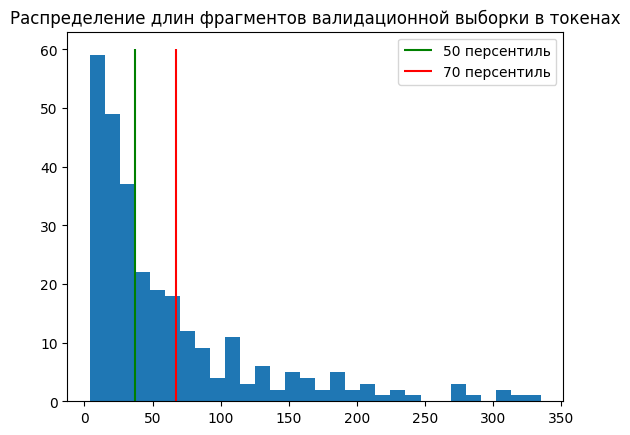

In [37]:
plt.hist([len(sentence) for sentence in val_tokens], bins=30)
plt.vlines([np.percentile([len(sentence) for sentence in val_tokens], 50)], [0], [60], label="50 персентиль", color="green")
plt.vlines([np.percentile([len(sentence) for sentence in val_tokens], 70)], [0], [60], label="70 персентиль", color="red")
plt.title('Распределение длин фрагментов валидационной выборки в токенах')
plt.legend()
plt.show()

Длины отзывов в токенах могут быть совершенно разными, однако для словаря из 300 токенов больше 50% отзывов меньше 50 токенов. 70-персентиль находится примерно на 60 токенах.  
Таким образом, мы эверистически будем дополнять отзывы до `60` токенов паддингом, а отзывы, что больше по длине - обрезать. Предполагаем, что основная информация отзыва, по которому можно сделать вывод о том, с какого типа проблемой столкнулся клиент, находится в начале отзыва, а концовка - это подробное объяснение, что именно было не так. Также в модели есть настройка, позволяющая менять длину входящего текста, так что можно посмотреть, насколько мы с этим параметром угадали

## Построение модели

Для обучения модели построим три, не считая файлов конфига, питоновских файла, которые находятся в пакете `negative_classification`.
- `data.py` для логики обработки данных и классов Dataset и LightningDataModule
- `model.py` для классов модели и функции get_result для вывода ответа модели
- `train.py` для тренировки модели

### data.py

Тут находятся функции, которые были рассмотрены выше в области `Предобработка данных`.  

Также здесь класс `LanduageModelDataset`, который наследуется от торчевского `Dataset`. Он принимает в себя уже лемматизированные и очищенные данные (те, что храняться в сохранённом txt-файле), а также размер chunk - длины отзыва, которую будет модель обрабатывать. Он осуществляет возврат очищенных и обрезанных (или дополненных паддингом) данных и класс  

`NegClassification_DataModule` класса `LightningDataModule` осуществляет предобработку данных, описанных выше, от получения xlsx-файла до сохранения лемматизированных и очищенных файлов в txt-формат. Также кидает данные в `LanduageModelDataset` и при тренировке возвращает модули `DataLoader`.  
Раздел test у него пустой, т.к. данных на тест не было

### model.py

Здесь находятся классы, по которым строится модель, а также функции для вывода уже финальной версии модели

Для построения модели с архитектурой энкодера трансформера с отдельным токеном класса используются следующие классы, написанные вручную:
1) `Class_Positions_Embeddings` - класс для создания позиционного кодирования и добавления токена класса, который модель в итоге и должна предсказать. Позиционное кодирование в данном случае реализуется через nn.Parameter, которые изменяются в ходе обучения модели, но можно использовать и статический вариант, вроде кодирования с помощью синусов и косинусов.
2) `MLP` - класс перцептрона для блока и для финальной классификации токена класса. Реализован через один входной и один выходной слой с возможностью повышения/понижения размерности.
3) `Attention` - класс внимания модели. Собственно, реализация классического внимания трансформера. Для увеличения продуктивности (повышения именно матричных операций для видеокарты) считается одна большая матрица, которая потом с помощью библиотеки einops делится на внимания голов.
4) `Block` - собственно, слой внимания вместе с нормализацией и перцептроном в конце. Есть настройка, в каком порядке использовать нормализацию - postnorm, то есть attention->skip_connection->norm->mlp_>skip_connection->norm, или prenorm, то есть norm->attention->skip_connection->norm->mlp_>skip_connection.
5) `Transformer` - класс трансформера. Просто несколько слоёв класса Block подряд.
6) `SpecificBERT` - класс, который собирает Class_Positions_Embeddings, Transformer и последний классификатор MLP вместе.
7) `SpecificBERT_Lightning` - обёрнутый в lighning SpecificBERT. Используется sheduler ReduceOnPlateau и кросс-энтропия в качестве loss-функции.

Также есть ещё класс ConfMatrixLogging, наследуемый от lightning.Callback. Он позволяет логировать на каждой эпохе обучения матрицу ответов модели по всем классам, что позволит детально посмотреть, что именно она не так предсказала.

### train.py

При запуске этого файла начинается обучение модели с заданными в конфиге параметрами. Управление конфигурационными файлами осуществляется с помощью `hydra`. 

Производится последовательное создание экземпляров класса `NegClassification_DataModule` и `SpecificBERT_Lightning`, а также различных callback для lightning: 
- `WandbLogger` для логирования процесса обучения модели на wandb
- `ModelCheckpoint` для сохранения лучших весов модели по метрике `val_loss`
- `LearningRateMonitor` для просмотра, как изменялся lr во время обучения с помощью scheduler
- `EarlyStopping` для завершения обучения в случае, если модель начала переобучаться
- `ConfMatrixLogging`, определённый в model.py

## Обучение модели

In [ ]:
# Обучение можно запустить через следующую команду. Гиперпарметры берутся из файла negative_classification/conf/config.yaml, идёт автоматически настроенное логирование на wandb:
# !python negative_classification/model_conversion.py

Прогон обучения модели осуществлялся с логированием результатов на [wandb](https://wandb.ai/lost_in_thoughts/NLP_Neg)

Названия запусков обучения строятся по следующему принципу:
- `v`: размер словаря
- `ch`: максимальная (и единая) длина отзыва в токенах
- `l`: количество слоёв у модели
- `h`: количество голов self-attention
- `emb`: размерность эмбеддинга
- `mlp`: размерность скрытого слоя в mlp-классификаторе
- `d`: значение dropout
- `lr`: изначальная скорость обучения

Первая попытка обучения (и как показала дальнейшая игра с гиперпараметрами, одна из наиболее успешых) со следующими параметрами:
- 300 слов в словаре
- 60 токенов для текста отзыовов
- 8 слоёв
- 4 головы self-attention
- 256 пространство эмбеддингов
- 512 размерность в последнем mlp-классификаторе
- 0.1 dropout
- 3е-4 lr  

получила точность f1-метрики в `0.75` на `9` (считая с 0) эпохе (после которой, очевидно, уже началось переобучение модели - при стабильно падающем loss на тренировочных данных функция потерь на валидации растёт).  

На wandb эта модель имеет название "v300-ch60-l8-h4-emb256-mlp512-d0.1-lr3e-4", фиолетового цвета

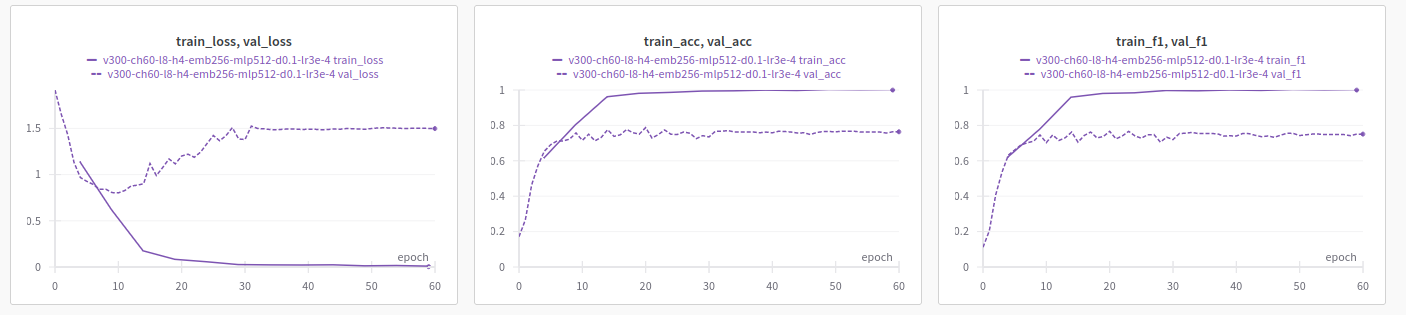

Матрица ответов модели по классам (которая также логируется на wandb на каждой эпохе):  

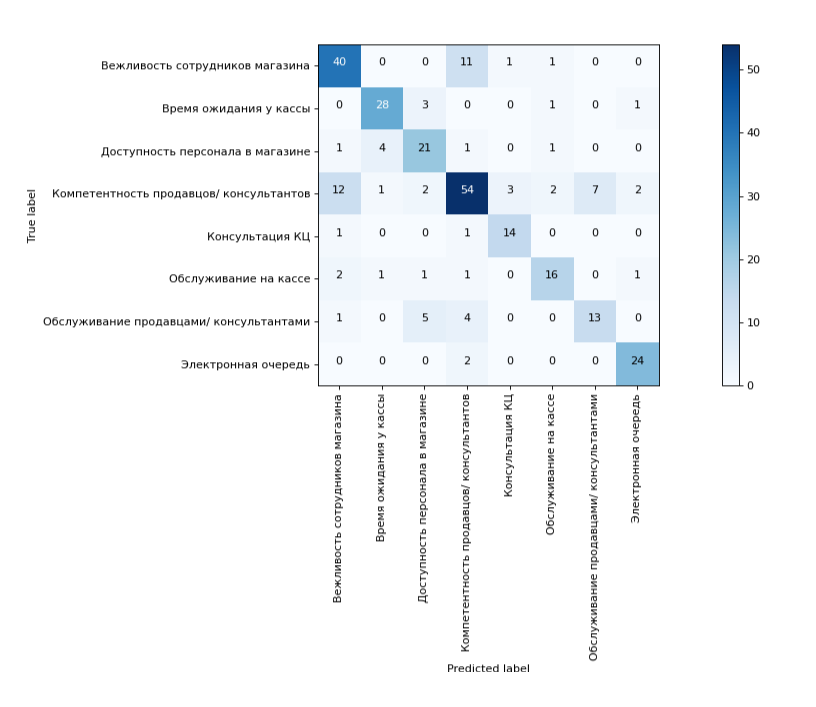

По данной матрице видно, что больше всего модель путает следующие классы:
- Компетентность продавцов/консультантов
- Вежливость сотрудников магазина
- Обслуживание продавцами/консультантами  

Что неудивительно, поскольку все эти классы непосредственно относятся к сотрудникам

Поперебирав различные гиперпараметры модели, выяснилось, что 0.75 - это средний ответ модели и одновременно её потолок. Изменение общей длины отзыва (chunk) тоже не дало никакого прироста (матрица при длине отзыва в токенах = 100):

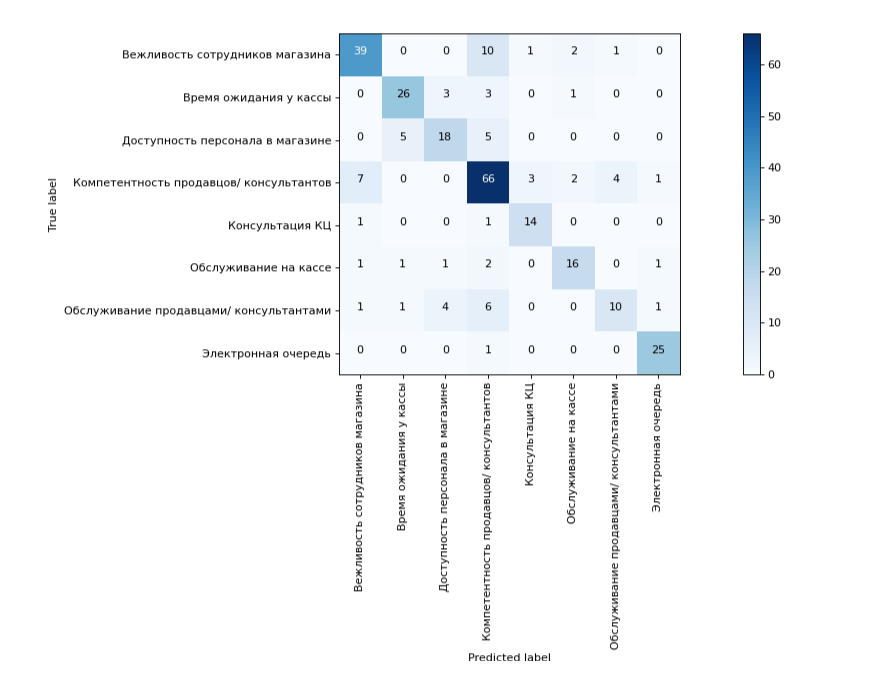

## Сохранение модели и её дальнейшее использование

Выберем модель "v300-ch60-l8-h4-emb256-mlp512-d0.1-lr3e-4" в качестве той, которую будем использовать для финальных результатов. Сохраним её в формат `onnx` (конвертация сделана в файле negative_classification/model_conversion.py, сами веса модели лежат по пути negative_classification/models/self_model.onnx).

Поскольку для модели в формале onnx необходим пример входных данных (в том числе батч), а размер проверочного датасета я не знаю, будет ли он делаиться нацело на на какое-либо число, я сделал входную размерность модели (1, 60) и подаю на вход по одному примеру, после чего добавляю в лист ответа. При известной (фиксированной) размерности входных данных можно будет более оптимизированно представить эту функцию

На граф модели с весами можно посмотреть в файле images/self_model.onnx.svg. Сохранил в виде векторной графики, т.к. граф получился узким и длинным

Для дальнейшего использования используем функцию `get_result`. Ниже приведён пример загрузки данных из Addtion.xlxs (датасет, который я попробовал сам собрать из интернета для проверки, файл построен по такому же принципу, как и исходный - три колонки, id, text, class).

In [10]:
from negative_classification.model import get_result
from negative_classification.data import load_dataset
import pandas as pd

x, y = load_dataset("negative_classification/dataset/Addition.xlsx")
to_pred = pd.Series(x)
answer = get_result(to_pred)
print(answer)

0            Доступность персонала в магазине
1     Компетентность продавцов/ консультантов
2     Компетентность продавцов/ консультантов
3             Вежливость сотрудников магазина
4     Компетентность продавцов/ консультантов
5     Компетентность продавцов/ консультантов
6             Вежливость сотрудников магазина
7             Вежливость сотрудников магазина
8             Вежливость сотрудников магазина
9     Компетентность продавцов/ консультантов
10            Вежливость сотрудников магазина
11                            Консультация КЦ
12    Компетентность продавцов/ консультантов
13                        Электронная очередь
14                      Обслуживание на кассе
15                            Консультация КЦ
16            Вежливость сотрудников магазина
17            Вежливость сотрудников магазина
18            Вежливость сотрудников магазина
19    Компетентность продавцов/ консультантов
20    Компетентность продавцов/ консультантов
21                            Конс

## Что ещё можно сделать?

Как будто бы 0.75 по f1 метрики - не самый лучший показатель. Что ищё можно сделать, чтобы этот результат улучшить?

- Взять уже предобученную модель, вроде RuBERT с haggingface, и настроить fine-tune дообучение последнего линейного классификатора
- Сгенерировать (или написать ручками:)) ещё примеров, особенно по недостающим классам, вроде "Консультация КЦ". Увеличение примеров маленьких классов может помочь с их определением, да и, в принципе, лучше, когда выборка равномерна по классам
- Из хардкорных методов: можно попробовать добавить в словарь те слова, которые точно кажутся важными и ключевыми (например, "колцентр") (или даже после генерации их BPE не найдёт), может, это как-то повлияет
- Усложнить предобработку: в отзывах встречаются ошибки в написаниях, сокращения. Если привести их к общему формату (тот же колцентр могут писать как КЦ, колцентр, кол-центр, колцетнр), это может серьёзно увеличить распознование моделью этих сущностей